In [1]:
#standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#yfinance API import
import yfinance as yf

**Background :** Drawdown is an important metric to evaluate the performance of an investment. Drawdown is defined as the percentage drop from the previous high level for our purpose.This notebook tries to answer to calculate the below three values
- all the drawdowns
- depth of each drawdown
- recovery time of each drawdown

The first three sections discuss downloading the data from yfinance, calculating the drawdown and visualizing it with the price series. SPY has been chosen as the time series.

Section 4 contains custom functions to calculate and plot drawdowns. You can find few examples in section 4.1


# Getting data
- In this section we import time series data from yahoo finance
- Our analysis is based on SPY (SPDR S&P 500 ETF Trust) prices from 2007-01-01 to 2021-11-01. This gives us an opportunity to compare the drawdowns between the 2008 financial crisis and the march 2020 sell off during the pandemic
- We use Adj Close price from the data for our calculations of drawdowns and recovery time

In [2]:
#getting data from yahoo finance
data_SPY = yf.download("SPY","2007-01-01","2021-11-01")

[*********************100%***********************]  1 of 1 completed


- Let's visualize our data set to get a better view

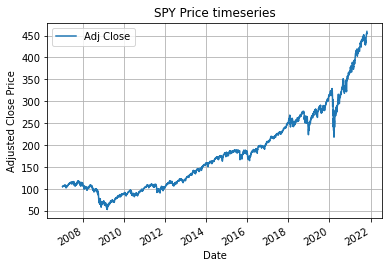

In [3]:
data_SPY["Adj Close"].plot()
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.title("SPY Price timeseries")
plt.grid()
plt.legend()

- Looking athe picture we can identify three major drawdowns (2008-2009,2018,2020). The later two had a quicker V shaped recovery, while the drawdown from financial crisis recovered over a period of 4 years

# Drawdown calculation
- In this section we try to calculate the drawdown, recovery time and depth of drawdowns
- The drawdown is calculated as the difference between present value and the previous maximum level. The drawdowns in the results represent the drop in the maximum level (positive values in percentage)
- The depth of drawn is calculated as the maximum drawdown at given previous maximum level
- Recovery time is calculated as the time taken to acheive a value greater than or equal to the high level

In [4]:
#Calculating cumulative max for the time series
data_SPY["Cumulative_Max"] = data_SPY["Adj Close"].cummax()

#creating a pandas dataframe for all the drawdowns
data_drawdowns = pd.DataFrame(np.nan, columns = ["high_level","high_level_time","recovered_level","recovered_timestamp","recovery_time","max_depth_drawdown"],index=[])

#Calculating unique cumulative peaks
cum_peaks = data_SPY["Cumulative_Max"].unique()

#calculating drawdowns at every time step
data_SPY["drawdown"] = (data_SPY["Cumulative_Max"]-data_SPY["Adj Close"])/data_SPY["Cumulative_Max"]*100

#calculating drawdown recovery for every unique cumulative peaks
for i in cum_peaks:
    high_level = i
    high_level_time = data_SPY[data_SPY["Adj Close"]==i].index.min()
    recovered_level = data_SPY[data_SPY["Adj Close"]>i]["Adj Close"].min()
    recovered_timestamp = data_SPY[data_SPY["Adj Close"]>i].index.min()
    recovery_time = (recovered_timestamp - high_level_time).days
    max_depth_drawdown = data_SPY[data_SPY["Cumulative_Max"]==i].drawdown.max()
    
    #creating a new row to be added to the results df
    new_row = {"high_level":high_level,"high_level_time":high_level_time,"recovered_level":recovered_level,"recovered_timestamp":recovered_timestamp,
              "recovery_time":recovery_time,"max_depth_drawdown":max_depth_drawdown}
    
    data_drawdowns= data_drawdowns.append(new_row,ignore_index=True)

In [5]:
print("Time Series starts from : ",data_SPY.index[0])
print("Time Series ends at : ",data_SPY.index[-1])
print("Number of drawdowns during this period :",data_drawdowns.shape[0]-1) #we are subracting 1 as the last value hasn't recovered yet

Time Series starts from :  2007-01-03 00:00:00
Time Series ends at :  2021-10-29 00:00:00
Number of drawdowns during this period : 443


- Now let's look the at the biggest drawdowns and the recovery times

In [6]:
data_drawdowns.sort_values(by="max_depth_drawdown",ascending=False)[:5]

,high_level,high_level_time,recovered_level,recovered_timestamp,recovery_time,max_depth_drawdown
32,118.243454,2007-10-09,118.287468,2012-08-16,1773.0,55.189443
355,328.919800,2020-02-19,329.202667,2020-08-10,173.0,33.717254
301,277.220947,2018-09-20,277.295807,2019-04-12,204.0,19.348901
184,189.034988,2015-07-20,189.054626,2016-04-18,273.0,13.022903
292,268.326599,2018-01-26,268.423981,2018-08-06,192.0,10.101869


- The biggest drawdown is around 55% percent during the 2008 financial crisis. It 1773 days (~4.8 years) to recover this drawdown in SPY 
- With a drawdown of ~33%, the pandemic causes the second biggest drawdown in this time series. But the recovery was swift and took only 173 days to regain the previous highs

In [7]:
#renaming high_level column to merge with our original data
data_drawdowns = data_drawdowns.rename(columns={"high_level":"Cumulative_Max"})
data_SPY_index = data_SPY.index
data_SPY = data_SPY.merge(data_drawdowns[["Cumulative_Max","max_depth_drawdown"]],on="Cumulative_Max")
data_SPY = data_SPY.set_index(data_SPY_index)

# Visualization of drawdowns
- In this section we attempt to visualize the drawdowns calculated earlier

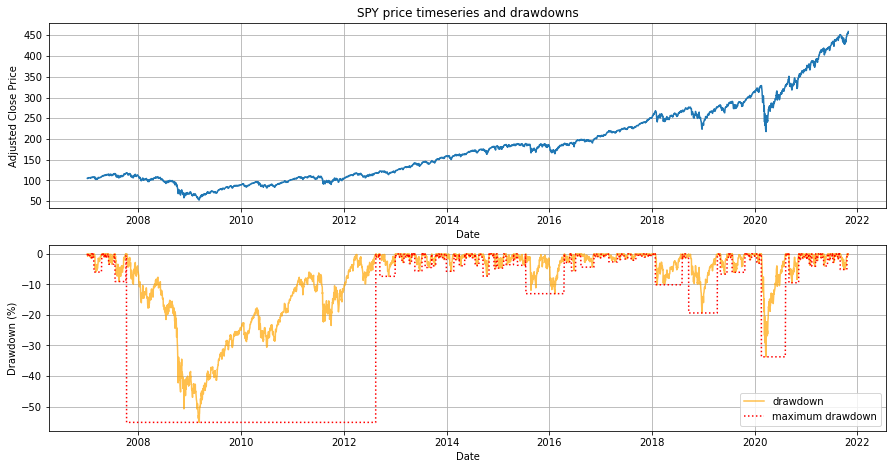

In [8]:
fig,ax = plt.subplots(2,1,figsize=(15,7.5))
ax[0].plot(data_SPY.index,data_SPY["Adj Close"])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Adjusted Close Price")
ax[0].set_title("SPY price timeseries and drawdowns")
ax[0].grid()

ax[1].plot(data_SPY.index,data_SPY["drawdown"]*-1,color="orange",alpha=0.7,label="drawdown")
ax[1].plot(data_SPY.index,data_SPY["max_depth_drawdown"]*-1,color="red",alpha=1,linestyle="dotted",label="maximum drawdown")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Drawdown (%)")
ax[1].legend()
ax[1].grid()
#ax[1].plot(data_drawdowns.index,data_drawdowns["max_depth_drawdown"],color="red")

# Custom function to calculate drawdowns
- This section contains a custom function to calculate drawdowns and their depth
- The price input (P(t)) is obtained from yahoo finance
- cal_drawdown calculates the drawdowns and maximum depth
- plot_drawdown visualizes the drawdowns in comparision with SPY

**cal_drawdown(ticker,start_date,end_date)**
-   *Input* - ticker (string), start_date (sting : YYYY-MM-DD), end_date (sting : YYYY-MM-DD)
-    *output* - dataframe containing drawdowns

**plot_drawdown(ticker,start_date,end_date)**
-   *Input* - ticker (string), start_date (sting : YYYY-MM-DD), end_date (sting : YYYY-MM-DD)
-    *output* - dataframes containing drawdowns of SPY and the ticker time series

In [9]:
def cal_drawdown(ticker,start_date,end_date):
    #getting data from yahoo finance
    data = yf.download(ticker,start_date,end_date)

    #Calculating cumulative max for the time series
    data["Cumulative_Max"] = data["Adj Close"].cummax()

    #creating a pandas dataframe for all the drawdowns
    data_drawdowns = pd.DataFrame(np.nan, columns = ["high_level","high_level_time","recovered_level","recovered_timestamp","recovery_time","max_depth_drawdown"],index=[])

    #Calculating unique cumulative peaks
    cum_peaks = data["Cumulative_Max"].unique()

    #calculating drawdowns at every time step
    data["drawdown"] = (data["Cumulative_Max"]-data["Adj Close"])/data["Cumulative_Max"]*100

    #calculating drawdown recovery for every unique cumulative peaks
    for i in cum_peaks:
        high_level = i
        high_level_time = data[data["Adj Close"]==i].index.min()
        recovered_level = data[data["Adj Close"]>i]["Adj Close"].min()
        recovered_timestamp = data[data["Adj Close"]>i].index.min()
        recovery_time = (recovered_timestamp - high_level_time).days
        max_depth_drawdown = data[data["Cumulative_Max"]==i].drawdown.max()

        #creating a new row to be added to the results df
        new_row = {"high_level":high_level,"high_level_time":high_level_time,"recovered_level":recovered_level,"recovered_timestamp":recovered_timestamp,
                  "recovery_time":recovery_time,"max_depth_drawdown":max_depth_drawdown}

        data_drawdowns= data_drawdowns.append(new_row,ignore_index=True)
        
    return data_drawdowns

In [10]:
def plot_drawdown(ticker,start_date,end_date):
    #getting data from yahoo finance
    data = yf.download(ticker,start_date,end_date)
    data_SPY = yf.download("SPY",start_date,end_date)

    #Calculating cumulative max for the time series
    data["Cumulative_Max"] = data["Adj Close"].cummax()
    data_SPY["Cumulative_Max"] = data_SPY["Adj Close"].cummax()

    #creating a pandas dataframe for all the drawdowns
    data_drawdowns = pd.DataFrame(np.nan, columns = ["high_level","high_level_time","recovered_level","recovered_timestamp","recovery_time","max_depth_drawdown"],index=[])
    data_drawdowns_SPY = pd.DataFrame(np.nan, columns = ["high_level","high_level_time","recovered_level","recovered_timestamp","recovery_time","max_depth_drawdown"],index=[])

    #Calculating unique cumulative peaks
    cum_peaks = data["Cumulative_Max"].unique()
    cum_peaks_SPY = data_SPY["Cumulative_Max"].unique()

    #calculating drawdowns at every time step
    data["drawdown"] = (data["Cumulative_Max"]-data["Adj Close"])/data["Cumulative_Max"]*100
    data_SPY["drawdown"] = (data_SPY["Cumulative_Max"]-data_SPY["Adj Close"])/data_SPY["Cumulative_Max"]*100

    #calculating drawdown recovery for every unique cumulative peaks
    for i in cum_peaks:
        high_level = i
        high_level_time = data[data["Adj Close"]==i].index.min()
        recovered_level = data[data["Adj Close"]>i]["Adj Close"].min()
        recovered_timestamp = data[data["Adj Close"]>i].index.min()
        recovery_time = (recovered_timestamp - high_level_time).days
        max_depth_drawdown = data[data["Cumulative_Max"]==i].drawdown.max()

        #creating a new row to be added to the results df
        new_row = {"high_level":high_level,"high_level_time":high_level_time,"recovered_level":recovered_level,"recovered_timestamp":recovered_timestamp,
                  "recovery_time":recovery_time,"max_depth_drawdown":max_depth_drawdown}

        data_drawdowns= data_drawdowns.append(new_row,ignore_index=True)
        
    for i in cum_peaks_SPY:
        high_level = i
        high_level_time = data_SPY[data_SPY["Adj Close"]==i].index.min()
        recovered_level = data_SPY[data_SPY["Adj Close"]>i]["Adj Close"].min()
        recovered_timestamp = data_SPY[data_SPY["Adj Close"]>i].index.min()
        recovery_time = (recovered_timestamp - high_level_time).days
        max_depth_drawdown = data_SPY[data_SPY["Cumulative_Max"]==i].drawdown.max()

        #creating a new row to be added to the results df
        new_row = {"high_level":high_level,"high_level_time":high_level_time,"recovered_level":recovered_level,"recovered_timestamp":recovered_timestamp,
                  "recovery_time":recovery_time,"max_depth_drawdown":max_depth_drawdown}

        data_drawdowns_SPY = data_drawdowns_SPY.append(new_row,ignore_index=True)
        
        
    #renaming high_level column to merge with our original data
    data_drawdowns = data_drawdowns.rename(columns={"high_level":"Cumulative_Max"})
    data_drawdowns_SPY = data_drawdowns_SPY.rename(columns={"high_level":"Cumulative_Max"})
    
    #storing index before merging
    data_SPY_index = data_SPY.index
    data_index = data.index
    
    #merging
    data_SPY = data_SPY.merge(data_drawdowns_SPY[["Cumulative_Max","max_depth_drawdown"]],on="Cumulative_Max")
    data = data.merge(data_drawdowns[["Cumulative_Max","max_depth_drawdown"]],on="Cumulative_Max")
    data_SPY = data_SPY.set_index(data_SPY_index)
    data = data.set_index(data_index)
    
    #finding 30-day rolling correlations with SPY
    rolling_corr_30day = data_SPY["drawdown"].rolling(30).corr(data["drawdown"])
    
    fig,ax = plt.subplots(3,1,figsize=(15,20))

    #plotting prices
    ax[0].plot(data_SPY.index,data_SPY["Adj Close"],label="SPY")
    ax[0].plot(data.index,data["Adj Close"],label=ticker)
    ax[0].set_xlabel("Date")
    ax[0].set_ylabel("Adjusted Close Price")
    name_1 = ticker + " vs. SPY price comparision"
    ax[0].set_title(name_1)
    ax[0].grid()
    ax[0].legend()

    #plotting drawdowns
    ax[1].plot(data_SPY.index,data_SPY["drawdown"]*-1,color="black",alpha=0.4,label="drawdown")
    ax[1].plot(data.index,data["drawdown"]*-1,alpha=0.4,label="drawdown")
    ax[1].plot(data_SPY.index,data_SPY["max_depth_drawdown"]*-1,color="black",alpha=1,label="maximum drawdown SPY")
    name_2 = "maximum drawdown "+ticker
    ax[1].plot(data.index,data["max_depth_drawdown"]*-1,alpha=1,label=name_2)
    name_3 = ticker +" vs. SPY drawdown comparision"
    ax[1].set_title(name_3)
    ax[1].set_xlabel("Date")
    ax[1].set_ylabel("Drawdown (%)")
    ax[1].legend()
    ax[1].grid()
    
    #plotting rolling correlation
    ax[2].plot(data_SPY.index,rolling_corr_30day,color="black",alpha=0.8,label="rolling correlation")
    ax[2].set_xlabel("Date")
    ax[2].set_ylabel("Rolling correlation")
    name_4 = ticker +" vs. SPY drawdown rolling correlation"
    ax[2].set_title(name_4)
    ax[2].legend()
    ax[2].grid()
    
    
    return data_drawdowns,data_drawdowns_SPY

## Few examples
- In this section we try to visualize drawdowns of few high volume stocks in comparision with SPY

**TSLA vs. SPY**
- From the below visualization we can see that TSLA recovered faster from the pandemic's drawdown than SPY
- The drawdowns of TSLA are substantially deeper than SPY


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


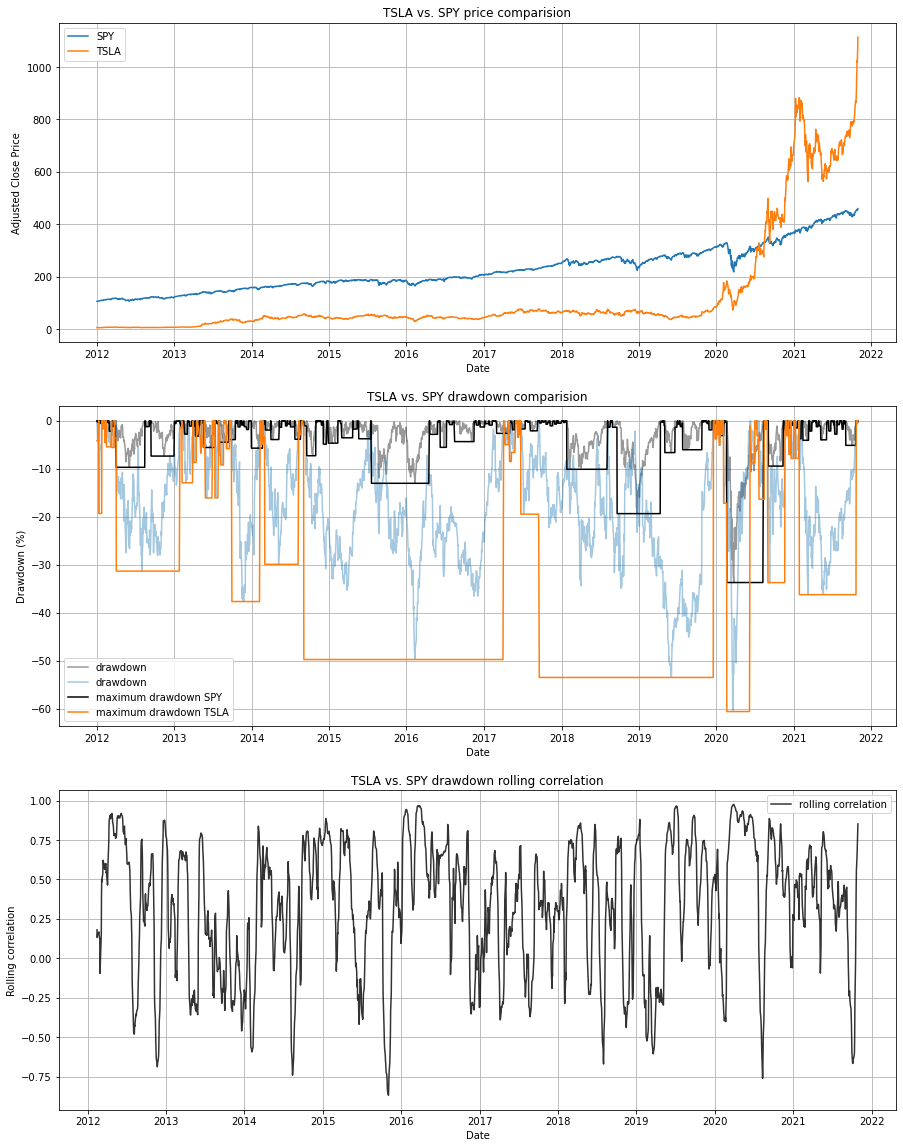

In [11]:
ticker = "TSLA"
start_date = "2012-01-01"
end_date = "2021-11-01"

data_drawdowns_TSLA,data_drawdowns_SPY = plot_drawdown(ticker,start_date,end_date)

**AAPL vs. SPY**
- AAPL recovered faster than SPY from its pandemic drawdown
- the drawdown depth shows a decreasing pattern for AAPL since 2019

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


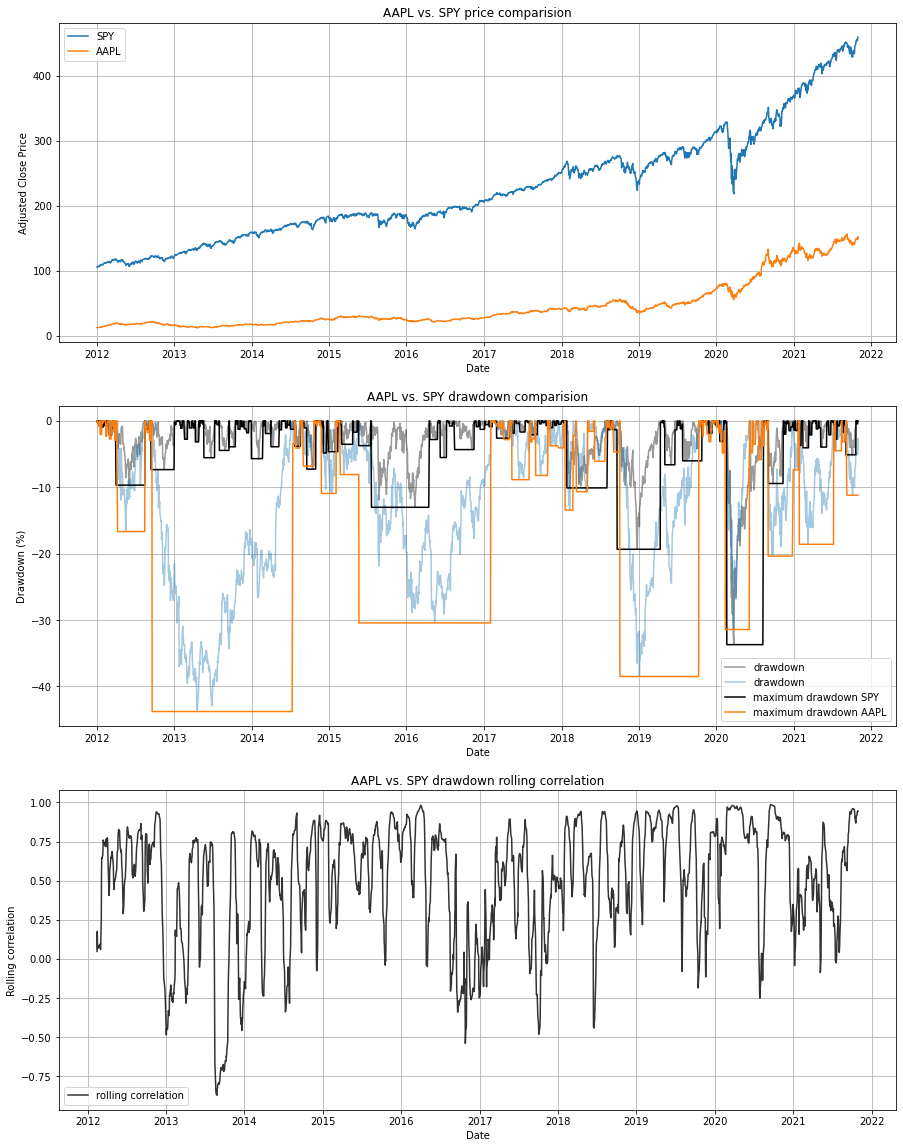

In [12]:
ticker = "AAPL"
start_date = "2012-01-01"
end_date = "2021-11-01"

data_drawdowns_AAPL,data_drawdowns_SPY = plot_drawdown(ticker,start_date,end_date)

**AMZN vs. SPY**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


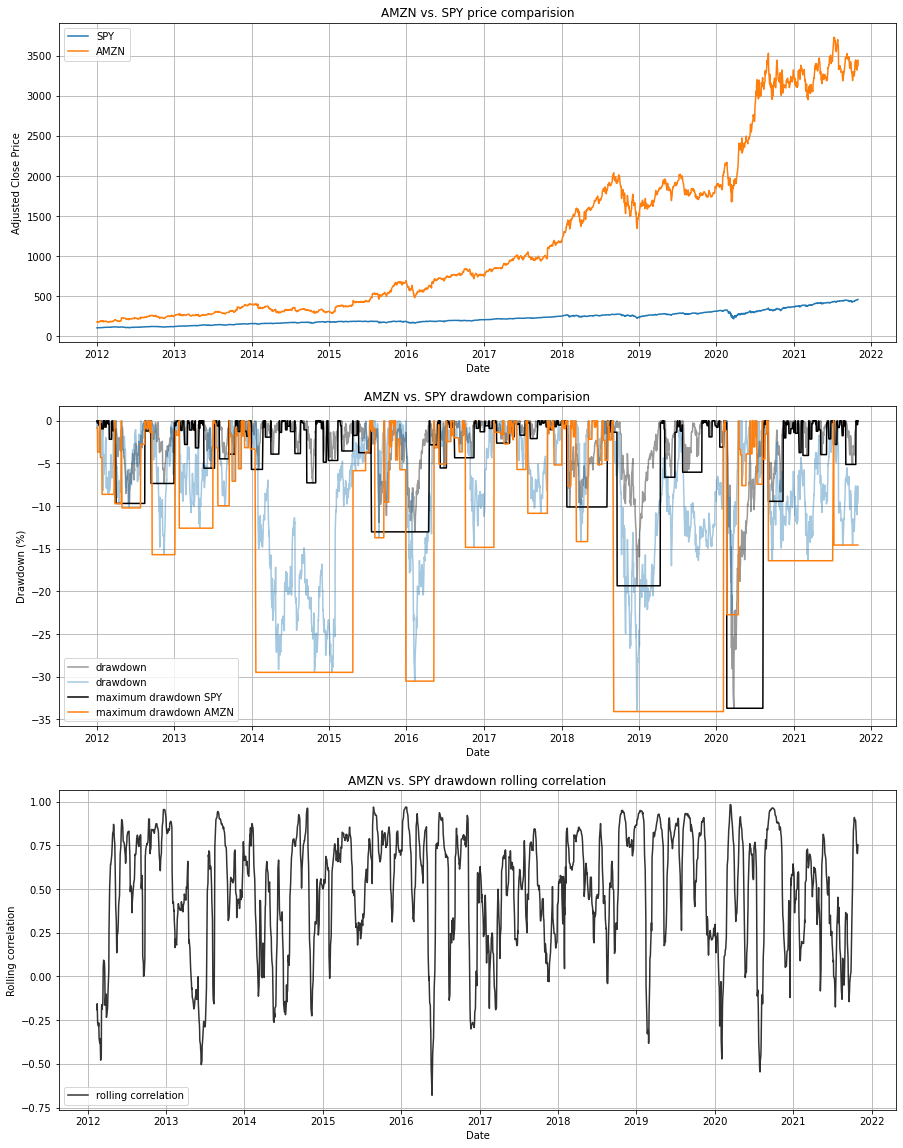

In [13]:
ticker = "AMZN"
start_date = "2012-01-01"
end_date = "2021-11-01"

data_drawdowns_AAPL,data_drawdowns_SPY = plot_drawdown(ticker,start_date,end_date)

**GME vs. SPY**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


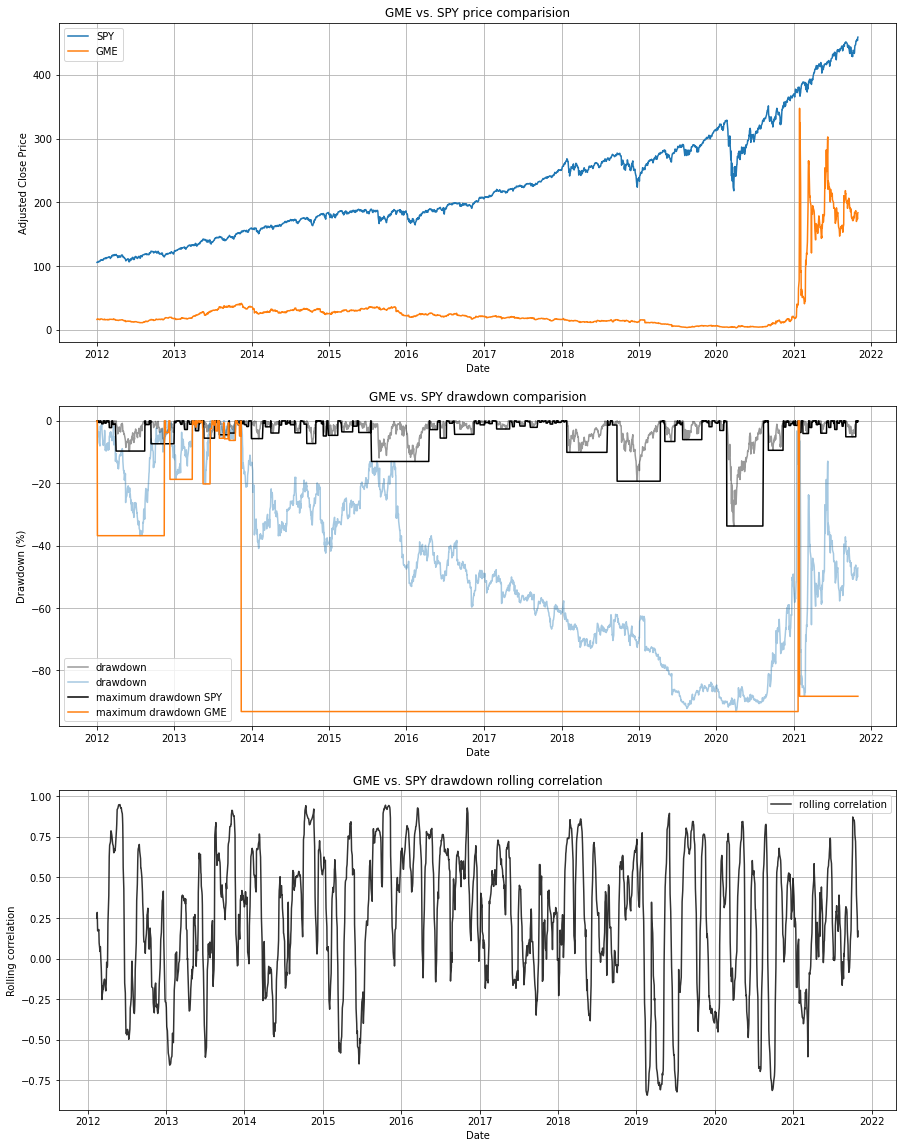

In [14]:
ticker = "GME"
start_date = "2012-01-01"
end_date = "2021-11-01"

data_drawdowns_AAPL,data_drawdowns_SPY = plot_drawdown(ticker,start_date,end_date)